In [3]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
# deterministic GPGPU operations
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ['TF_CUDNN_DETERMINISTIC']='1'
# turn off warnings and info
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ["AUTOGRAPH_VERBOSITY"] = "2"

import numpy as np
import tensorflow as tf

from datasets import get_mnist
from datasets import get_cifar_10_grayscale
from datasets import mnist_mean, mnist_std
from models import get_mlp as get_mlp
from experiment import run
import alphabet
import artifacters
import utils

def experiment(exp_name=None,
        dataset=None,
        ood_dataset=None,
        mean=None,
        std=None,
        model=None,
        lr=None,
        ds_l=None,
        ds_ood_l=None,
        batch_size=None,
        n_canaries=None,
        epochs=None):

    seed = 123
    utils.g_seed = seed
    utils.set_seed()

    c_indx = np.random.randint(0, ds_l, (n_canaries))
    artifact = alphabet.get_letter(0)
    artifact_offset = 1
    artifacter = artifacters.ArtifacterRandom(artifact_offset, artifact, None, ds_ood_l)
    
    run(
        exp_name=exp_name,
        seed=seed,
        epochs=epochs,
        batch_size=batch_size,
        learning_rate=lr,
        patience=10,
        n_outputs=10,
        loss_function=tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=False),
        n_checkpoints='auto',
        artifacter=artifacter,
        get_model=model,
        get_dataset=dataset,
        get_ood_dataset=ood_dataset,
        mean=mean,
        std=std,
        n_leaky_models=c_indx,
        hardness='tracin',
        run_train_leaky_models=True,
        run_eval=True,
        optimizer_type='adam',
        canary_indices=c_indx)

experiment(exp_name='mnist_mlp', dataset=get_mnist,
    ood_dataset=get_cifar_10_grayscale, mean=mnist_mean,
    std=mnist_std, model=get_mlp, lr=3e-4, ds_l=60000, ds_ood_l=50000, batch_size=128, n_canaries=10, epochs=100)


Train canary 0
Create tf datasets
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
INFO:tensorflow:Converted call: <function Model.make_train_function.<locals>.train_function at 0x7f4364d763b0>
    args: (<tensorflow.py

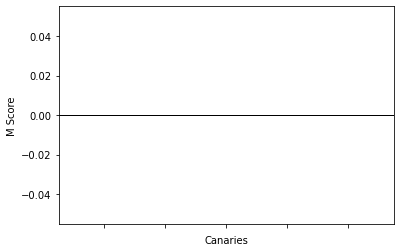

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_palette('tab10')

alpha = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

m = 'M2'

def plot(exp_name):
    

    # directory of the models trained with the canaries
    exp_eval = f'results/{exp_name}/eval.csv'
    # load csv
    df = pd.read_csv(exp_eval)
    
    if m != 'M2':
        df[m] = df[m] * -1
        
    plt.figure()
    ax = sns.scatterplot(data=df, x='canary', color='black')
    ax.axhline(0, color='black', linewidth=1)
    ax.set_xlabel('Canaries')
    ax.set_ylabel('M Score')
    ax.axes.xaxis.set_ticklabels([])
    plt.show()
    

m = 'M2'
plot('mnist_mlp')
